# Project
Fetch the data here: https://www.kaggle.com/datasets/arnaud58/landscape-pictures?resource=download

Unzip the data and add it to the project folder under `/data`

In [407]:
#%%capture
#!unzip archive.zip -d data

## Dependencies

In [4]:
import torch

from torchvision.transforms import Compose, ToTensor, RandomResizedCrop, RandomHorizontalFlip, RandomRotation, Grayscale, Normalize
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
import PIL.Image as Image
import os
import torch.optim as optim
import matplotlib.pyplot as plt

import random
from math import ceil


## Dataset 

In [5]:
class LandscapeDataset(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        self.all_imgs = [file for file in os.listdir(main_dir) if file.endswith((".jpg", 'JPG', 'jpeg',"png"))]

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

In [39]:
image_transforms = Compose([
    ToTensor(), 
    #RandomRotation(180),
    Normalize(0.5, 0.5),
    Grayscale(num_output_channels=1),
    RandomResizedCrop((128,128), (0.6, 0.6)), 
    RandomHorizontalFlip()])
data = LandscapeDataset("all_data", image_transforms)

image_transforms_colour = Compose([
    ToTensor(), 
    #RandomRotation(180),
    Normalize(0.5, 0.5),
    RandomResizedCrop((128,128), (0.6, 0.6)), 
    RandomHorizontalFlip()])
dataColour = LandscapeDataset("all_data", image_transforms_colour)

## Displaying Images
Some image showing helper functions

In [7]:
from requests import patch


def show(image):
    plt.imshow(image.permute(1, 2, 0), cmap='gray')
    
def get_show_image(dataset, n=None):
    image = dataset[n if n is not None else random.randint(0, len(dataset))]
    show(image)
    
def show_images(images):
    n, m = (1,4) if len(images) <= 4 else (1, ceil(len(images)/4))
    fig, axs = plt.subplots(n, m, figsize=(14, 14), squeeze=False)
    for i in range(n):
        for j in range(m):
            image = images[i*4 + j]
            axs[i, j].imshow(image.permute(1, 2, 0), cmap='gray')
            axs[i, j].axis("off")
    fig.show()
    
def show_image_matrix(dataset, n=3, img_idx=None, fixed=False):
    img_idx = random.randint(0, len(dataset)) if fixed else None
    # make a n x n grid of images
    fig, axs = plt.subplots(n, n, figsize=(14, 14))
    for i in range(n):
        for j in range(n):
            image = dataset[img_idx if img_idx is not None else random.randint(0, len(dataset))]
            axs[i, j].imshow(image.permute(1, 2, 0), cmap='gray')
            axs[i, j].axis("off")
    fig.show()
    
# fetch a random 64x64 patch from each image in the batch
def get_patchs(images, patch_size=64, rand=False):
    images = images.detach().clone()
    w, h = images.shape[-2:]
    i = int((w/2) - (patch_size/2)) if not rand else random.randint(0, w - patch_size)
    j = int((h/2) - (patch_size/2)) if not rand else random.randint(0, h - patch_size)
    patchs = images[..., i:i+patch_size, j:j+patch_size].detach().clone()
    images[..., i:i+patch_size, j:j+patch_size] = 0
    return (i, j), patchs, images

def fill_patch(patch_pos, images, patches):
    i, j = patch_pos
    patch_size = patches.shape[-1]
    images = images.detach().clone()
    images[..., i:i+patch_size, j:j+patch_size] = patches
    return images

### Transformation Display

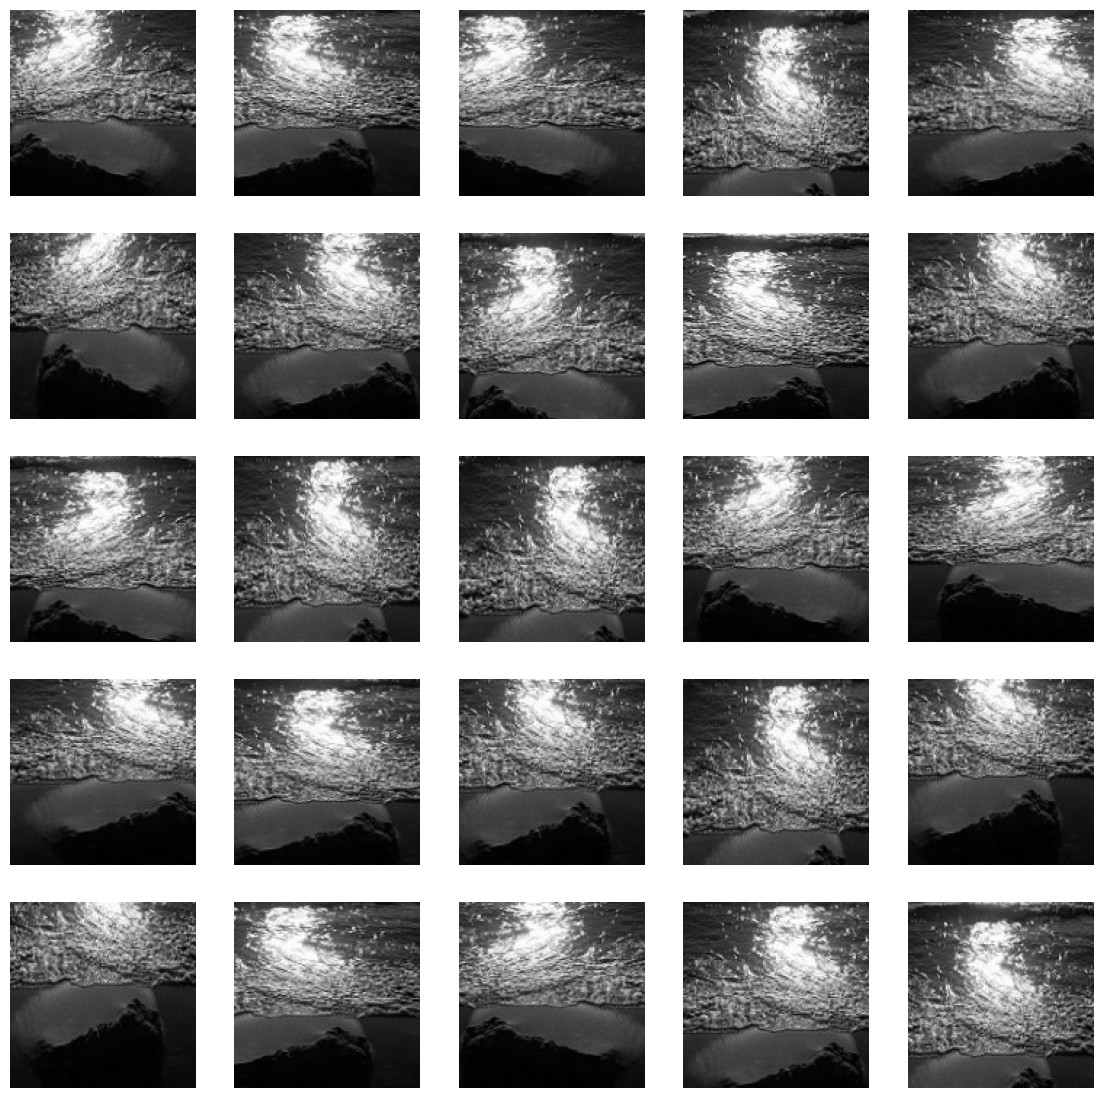

In [8]:
show_image_matrix(data, 5, fixed=True)

### Random imaged and their transformation

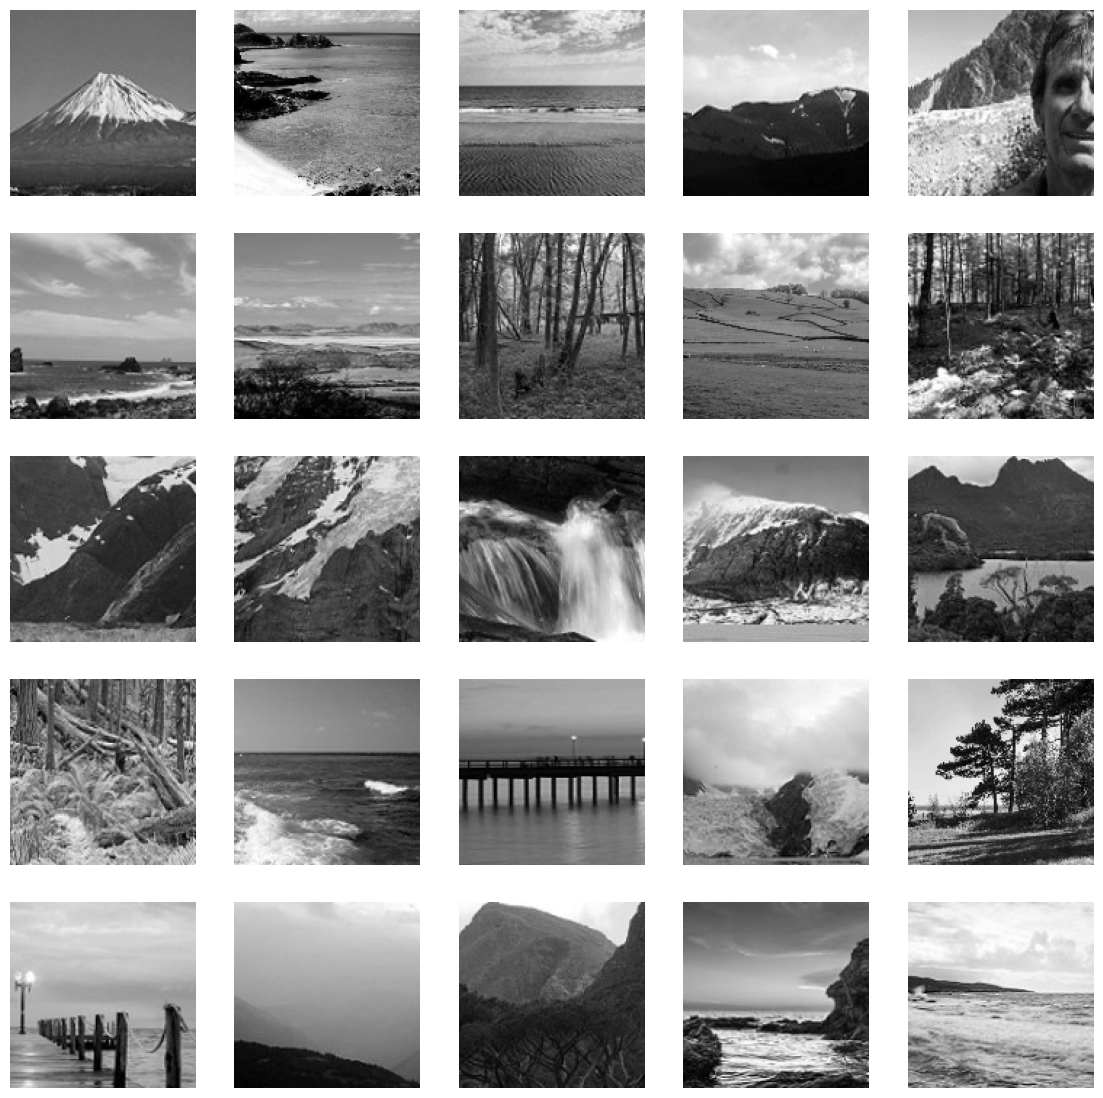

In [9]:
show_image_matrix(data, 5, fixed=False)

## Model

In [10]:
from torch.nn import *

In [65]:
class AutoEncoder(Module):
    def __init__(self):
        super().__init__()
        self.encoder = Sequential(
            Conv2d(1, 64, 4, stride=2, padding=1),
            BatchNorm2d(64),
            LeakyReLU(),
            Conv2d(64, 64, 4, stride=2, padding=1),
            BatchNorm2d(64),
            LeakyReLU(),
            Conv2d(64, 128, 4, stride=2, padding=1),
            BatchNorm2d(128),
            LeakyReLU(),
            Conv2d(128, 256, 4, stride=2, padding=1),
            BatchNorm2d(256),
            LeakyReLU(),
            Conv2d(256, 512, 4, stride=2, padding=1),
            BatchNorm2d(512),
            LeakyReLU(),
            Conv2d(512, 4000, 4),
            BatchNorm2d(4000),
            LeakyReLU(),
        )
         
        self.decoder = Sequential(
            ConvTranspose2d(4000, 512, 4),
            BatchNorm2d(512),
            ReLU(),
            ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            BatchNorm2d(256),
            ReLU(),
            ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            BatchNorm2d(128),
            ReLU(),
            ConvTranspose2d(128, 32, 4, stride=2, padding=1),
            BatchNorm2d(32),
            ReLU(),
            ConvTranspose2d(32, 1, 4, stride=2, padding=1),
            BatchNorm2d(1),
            Tanh()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [66]:
class AutoEncoderColour(Module):
    def __init__(self):
        super().__init__()
        self.encoder = Sequential(
            Conv2d(3, 64, 4, stride=2, padding=1),
            BatchNorm2d(64),
            LeakyReLU(),
            Conv2d(64, 64, 4, stride=2, padding=1),
            BatchNorm2d(64),
            LeakyReLU(),
            Conv2d(64, 128, 4, stride=2, padding=1),
            BatchNorm2d(128),
            LeakyReLU(),
            Conv2d(128, 256, 4, stride=2, padding=1),
            BatchNorm2d(256),
            LeakyReLU(),
            Conv2d(256, 512, 4, stride=2, padding=1),
            BatchNorm2d(512),
            LeakyReLU(),
            Conv2d(512, 4000, 4),
            BatchNorm2d(4000),
            LeakyReLU(),
        )
         
        self.decoder = Sequential(
            ConvTranspose2d(4000, 512, 4),
            BatchNorm2d(512),
            ReLU(),
            ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            BatchNorm2d(256),
            ReLU(),
            ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            BatchNorm2d(128),
            ReLU(),
            ConvTranspose2d(128, 32, 4, stride=2, padding=1),
            BatchNorm2d(32),
            ReLU(),
            ConvTranspose2d(32, 3, 4, stride=2, padding=1),
            BatchNorm2d(3),
            Tanh()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [12]:
model = AutoEncoder()
criterion = MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [13]:
from torchsummary import summary

summary(model.to("cuda"), (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,088
       BatchNorm2d-2           [-1, 64, 64, 64]             128
         LeakyReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 32, 32]          65,600
       BatchNorm2d-5           [-1, 64, 32, 32]             128
         LeakyReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 16, 16]         131,200
       BatchNorm2d-8          [-1, 128, 16, 16]             256
         LeakyReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10            [-1, 256, 8, 8]         524,544
      BatchNorm2d-11            [-1, 256, 8, 8]             512
        LeakyReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 512, 4, 4]       2,097,664
      BatchNorm2d-14            [-1, 51

## Train model

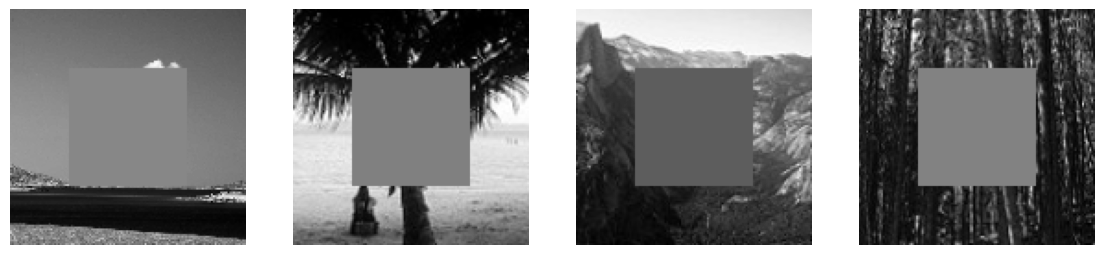

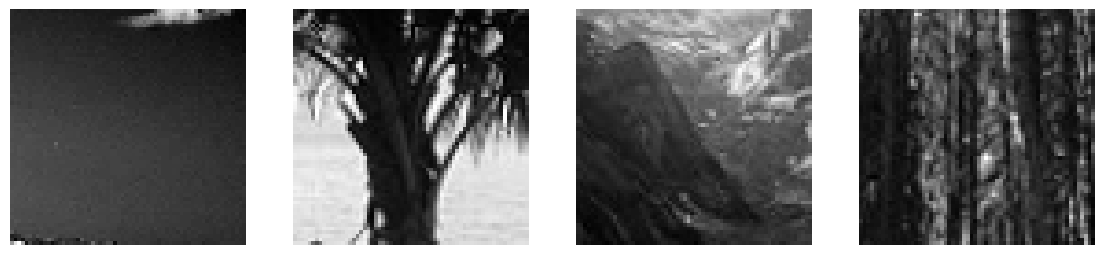

In [14]:
loader = DataLoader(data, batch_size=4, shuffle=True)
img = loader.__iter__().__next__()
patch_pos, patches, images = get_patchs(img)
show_images(images)
show_images(patches)

In [19]:
from torch.utils.tensorboard import SummaryWriter

def train(model, data, criterion, optimizer, batch_size, epochs=10):
    writer = SummaryWriter("runs/final_100_64_cae_gcp")
    device = torch.device("cuda")
    model.to(device).cuda()
    loader = DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=12)
    iters = 1
    for epoch in range(epochs):
        running_loss = 0.0
        for i, batch in enumerate(loader):
            # ===============prep-rocessing==================
            _, patches, images = get_patchs(batch)
            images_on_gpu = images.to(device).cuda()
            patches_on_gpu = patches.to(device).cuda()
            # ==================forward======================
            optimizer.zero_grad()
            output = model(images_on_gpu)
            patch_loss = criterion(patches_on_gpu, output)
            # ==================log======================
            writer.add_scalar("Loss/train", patch_loss, iters)
            # ==================backward=====================
            patch_loss.backward()
            optimizer.step()
            iters += 1
        print(f"Epoch {epoch + 1} of {epochs}")

    writer.close()


In [20]:
model = AutoEncoder()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train(model, data, criterion, optimizer, 64, 100)

Epoch 1 of 100
Epoch 2 of 100
Epoch 3 of 100
Epoch 4 of 100
Epoch 5 of 100
Epoch 6 of 100
Epoch 7 of 100
Epoch 8 of 100
Epoch 9 of 100
Epoch 10 of 100
Epoch 11 of 100
Epoch 12 of 100
Epoch 13 of 100
Epoch 14 of 100
Epoch 15 of 100
Epoch 16 of 100
Epoch 17 of 100
Epoch 18 of 100
Epoch 19 of 100
Epoch 20 of 100
Epoch 21 of 100
Epoch 22 of 100
Epoch 23 of 100
Epoch 24 of 100
Epoch 25 of 100
Epoch 26 of 100
Epoch 27 of 100
Epoch 28 of 100
Epoch 29 of 100
Epoch 30 of 100
Epoch 31 of 100
Epoch 32 of 100
Epoch 33 of 100
Epoch 34 of 100
Epoch 35 of 100
Epoch 36 of 100
Epoch 37 of 100
Epoch 38 of 100
Epoch 39 of 100
Epoch 40 of 100
Epoch 41 of 100
Epoch 42 of 100
Epoch 43 of 100
Epoch 44 of 100
Epoch 45 of 100
Epoch 46 of 100
Epoch 47 of 100
Epoch 48 of 100
Epoch 49 of 100
Epoch 50 of 100
Epoch 51 of 100
Epoch 52 of 100
Epoch 53 of 100
Epoch 54 of 100
Epoch 55 of 100
Epoch 56 of 100
Epoch 57 of 100
Epoch 58 of 100
Epoch 59 of 100
Epoch 60 of 100
Epoch 61 of 100
Epoch 62 of 100
Epoch 63 of 100
E

In [40]:
model = AutoEncoderColour()
criterion = MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train(model, dataColour, criterion, optimizer, 64, 100)

Epoch 1 of 100
Epoch 2 of 100
Epoch 3 of 100
Epoch 4 of 100
Epoch 5 of 100
Epoch 6 of 100
Epoch 7 of 100
Epoch 8 of 100
Epoch 9 of 100
Epoch 10 of 100
Epoch 11 of 100
Epoch 12 of 100
Epoch 13 of 100
Epoch 14 of 100
Epoch 15 of 100
Epoch 16 of 100
Epoch 17 of 100
Epoch 18 of 100
Epoch 19 of 100
Epoch 20 of 100
Epoch 21 of 100
Epoch 22 of 100
Epoch 23 of 100
Epoch 24 of 100
Epoch 25 of 100
Epoch 26 of 100
Epoch 27 of 100
Epoch 28 of 100
Epoch 29 of 100
Epoch 30 of 100
Epoch 31 of 100
Epoch 32 of 100
Epoch 33 of 100
Epoch 34 of 100
Epoch 35 of 100
Epoch 36 of 100
Epoch 37 of 100
Epoch 38 of 100
Epoch 39 of 100
Epoch 40 of 100
Epoch 41 of 100
Epoch 42 of 100
Epoch 43 of 100
Epoch 44 of 100
Epoch 45 of 100
Epoch 46 of 100
Epoch 47 of 100
Epoch 48 of 100
Epoch 49 of 100
Epoch 50 of 100
Epoch 51 of 100
Epoch 52 of 100
Epoch 53 of 100
Epoch 54 of 100
Epoch 55 of 100
Epoch 56 of 100
Epoch 57 of 100
Epoch 58 of 100
Epoch 59 of 100
Epoch 60 of 100
Epoch 61 of 100
Epoch 62 of 100
Epoch 63 of 100
E

## Own internal test set (alex)

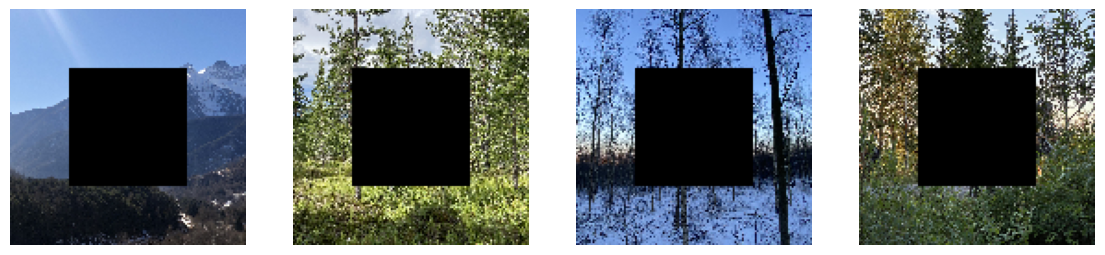

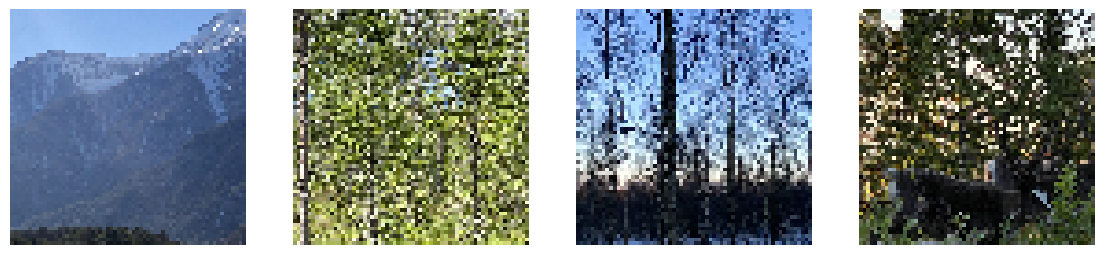

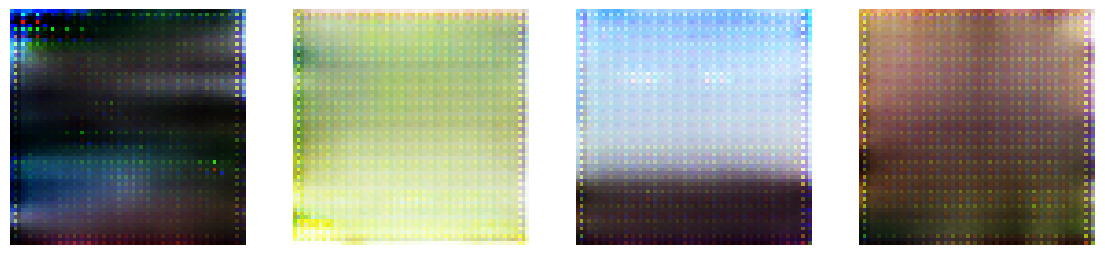

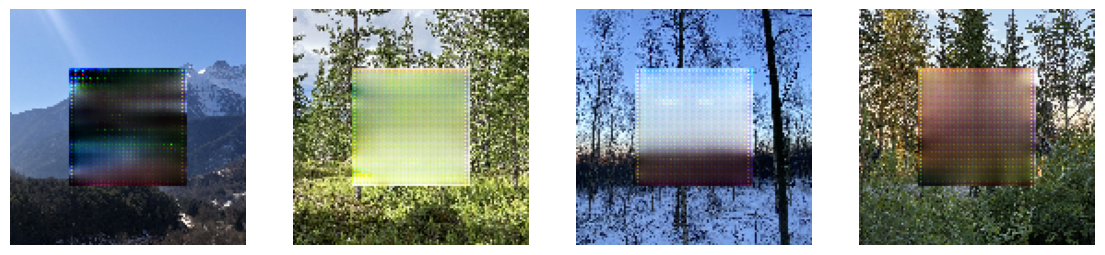

In [53]:
image_transforms_colour_f = Compose([
    ToTensor(), 
    #RandomRotation(180),
    #Normalize(0.5, 0.5),
    RandomResizedCrop((128,128), (0.6, 0.6)), 
    RandomHorizontalFlip()])

test_data = LandscapeDataset("own_data", image_transforms_colour_f)
test_loader = DataLoader(test_data, batch_size=4, shuffle=True)
img = test_loader.__iter__().__next__()
patch_pos, patches, images = get_patchs(img)
show_images(images)
show_images(patches)

model.to("cpu")
predicted_patches = model(images).cpu().detach()

show_images((predicted_patches+1)/2)
show_images(fill_patch(patch_pos, images, (predicted_patches+1)/2))


# Let's try with adverserial loss

In [62]:
class Discriminator(Module):
    def __init__(self):
        super().__init__()
        self.conv = Sequential(
            Conv2d(1, 64, 4, stride=2, padding=1),
            LeakyReLU(),
            Conv2d(64, 128, 4, stride=2, padding=1),
            BatchNorm2d(128),
            LeakyReLU(),
            Conv2d(128, 256, 4, stride=2, padding=1),
            BatchNorm2d(256),
            LeakyReLU(),
            Conv2d(256, 512, 4, stride=2, padding=1),
            Flatten(),
            Linear(8192, 1),
            Sigmoid()
        )
 
    def forward(self, x):
        return self.conv(x)
summary(Discriminator().cuda(), (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,088
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,200
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,544
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,664
          Flatten-10                 [-1, 8192]               0
           Linear-11                    [-1, 1]           8,193
          Sigmoid-12                    [-1, 1]               0
Total params: 2,763,457
Trainable params: 2,763,457
Non-trainable params: 0
---------------------------

In [63]:
class DiscriminatorColour(Module):
    def __init__(self):
        super().__init__()
        self.conv = Sequential(
            Conv2d(3, 64, 4, stride=2, padding=1),
            LeakyReLU(),
            Conv2d(64, 128, 4, stride=2, padding=1),
            BatchNorm2d(128),
            LeakyReLU(),
            Conv2d(128, 256, 4, stride=2, padding=1),
            BatchNorm2d(256),
            LeakyReLU(),
            Conv2d(256, 512, 4, stride=2, padding=1),
            Flatten(),
            Linear(8192, 1),
            Sigmoid()
        )
 
    def forward(self, x):
        return self.conv(x)
summary(DiscriminatorColour().cuda(), (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,136
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,200
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,544
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,664
          Flatten-10                 [-1, 8192]               0
           Linear-11                    [-1, 1]           8,193
          Sigmoid-12                    [-1, 1]               0
Total params: 2,765,505
Trainable params: 2,765,505
Non-trainable params: 0
---------------------------

## New training function w/Adverserial support

In [28]:
def train_new_new(
        generator, 
        optimizer_g, 
        discriminator, 
        optimizer_d, 
        alpha, 
        beta, 
        data, 
        batch_size, 
        epochs=10
):
    writer = SummaryWriter()
    device = torch.device("cuda")
    generator.to(device).cuda()
    discriminator.to(device).cuda()
    loader = DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=12)
    
    iters = 1
    for epoch in range(epochs):
        for i, batch in enumerate(loader):
            patch_pos, patches, images = get_patchs(batch)
            padded_patch_pos, padded_patches, _ = get_patchs(batch, patch_size=64+14)

            imgs = images.to(device).cuda()
            cutouts = patches.to(device).cuda()
            padded_patches = padded_patches.to(device).cuda()
            optimizer_g.zero_grad()

            # generate fake images
            fake_imgs = generator(imgs)

            # adversarial and pixelwise loss
            fake_discriminate = discriminator(fake_imgs)
            g_adv = BCELoss()(fake_discriminate, torch.ones_like(fake_discriminate))
            g_pixel = MSELoss()(fake_imgs, cutouts)

            adv_factor = 0.001

            g_loss = adv_factor * g_adv + (1 - adv_factor) * g_pixel

            g_loss.backward()
            optimizer_g.step()

            # TRAIN DISCRIMINATOR

            optimizer_d.zero_grad()

            # real images
            real_discriminate = discriminator(padded_patches)
            real_loss = BCELoss()(real_discriminate, torch.ones_like(real_discriminate))
            fake_loss = BCELoss()(discriminator(fake_imgs.detach()), torch.zeros_like(fake_discriminate))

            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_d.step()

            # ==================log======================
            losses = dict(G=g_pixel, D=d_loss, C=g_loss)
            writer.add_scalars("Loss/train", losses, iters)
            disc_predictions = dict(real=torch.mean(real_discriminate), fake=torch.mean(fake_discriminate))
            writer.add_scalars("Predictions/D", disc_predictions, iters)
            iters += 1

In [58]:
def train_new(
        generator, 
        optimizer_g, 
        discriminator, 
        optimizer_d, 
        alpha, 
        beta, 
        data, 
        batch_size, 
        epochs=10,
        writer_name="default"
):
    writer_path = None if writer_name == "default" else "runs/"+writer_name
    writer = SummaryWriter(writer_path)
    device = torch.device("cuda")
    generator.to(device).cuda()
    discriminator.to(device).cuda()
    loader = DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=12)
    
    iters = 1
    for epoch in range(epochs):
        for i, batch in enumerate(loader):
            # PREPARE IMAGES
            _, real_patches, full_images = get_patchs(batch)
            _, real_padded_patches, _ = get_patchs(batch, patch_size=64+14)
            # ADD TO GPU
            full_images = full_images.to(device).cuda()
            real_patches = real_patches.to(device).cuda()
            real_padded_patches = real_padded_patches.to(device).cuda()
            
            # ==========TRAIN GENERATOR===============
            # ZERO GRADIENTS IN MODEL
            generator.zero_grad()

            # GENERATE IMAGES FROM GENERATOR
            generated_images = generator(full_images)

            # GET DISCRIMINATOR PREDICTIONS ON GENERATED IMAGES
            predictions_on_generated = discriminator(fill_patch((7,7), real_padded_patches, generated_images))

            # CALCULATE THE ADVERSERIAL AND MSE LOSS
            generator_adv_loss = BCELoss()(predictions_on_generated, torch.ones_like(predictions_on_generated))
            generator_pixel_loss = MSELoss()(generated_images, real_patches)
            # COMBINE THE LOSS
            generator_combined_loss = alpha * generator_pixel_loss + beta * generator_adv_loss
            # BACKPROPAGATE
            generator_combined_loss.backward()
            optimizer_g.step()

            # =========TRAIN DISCRIMINATOR===============
            # ZERO GRADIENTS IN MODEL
            discriminator.zero_grad()

            # GET DISCRIMINATOR PREDICTIONS ON REAL IMAGES
            predictions_on_real = discriminator(real_padded_patches)
            # GENERATE IMAGES FROM GENERATOR
            predictions_on_fake = discriminator(fill_patch((7,7), real_padded_patches, generated_images.detach()))
            
            # CALCULATE THE ADVERSERIAL LOSS
            real_loss = BCELoss()(predictions_on_real, torch.ones_like(predictions_on_real))
            fake_loss = BCELoss()(predictions_on_fake, torch.zeros_like(predictions_on_real))
            #COMBINE THE LOSS
            d_loss = real_loss + fake_loss
            # BACKPROPAGATE
            d_loss.backward()
            optimizer_d.step()

            # ==================LOG======================
            losses = dict(G=generator_pixel_loss, D=d_loss, C=generator_combined_loss)
            writer.add_scalars("Loss/train", losses, iters)
            disc_predictions = dict(real=torch.mean(predictions_on_real), fake=torch.mean(predictions_on_generated))
            writer.add_scalars("Predictions/D", disc_predictions, iters)
            iters += 1
        print(f"Epoch {epoch + 1} of {epochs}")

# Train the model

In [71]:
model_dir = "models/100_64_gcp"

device = torch.device("cuda")
model = AutoEncoder()
model.load_state_dict(torch.load(f"{model_dir}/model_gcp.pt"))
model.to(torch.device("cuda"))

device = torch.device("cuda")
discriminator = Discriminator()
discriminator.load_state_dict(torch.load(f"{model_dir}/disc_cpu.pt"))
discriminator.to(torch.device("cuda"))


Discriminator(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=8192, out_features=1, bias=True)
    (11): Sigmoid()
  )
)

In [ ]:
#initialise weights normal
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

discriminator = Discriminator().apply(weights_init_normal)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=1e-5, betas=(0.5, 0.999))

model = AutoEncoder().apply(weights_init_normal)
model_optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.5, 0.999))

data = LandscapeDataset("all_data", image_transforms)

train_new(model, 
          model_optimizer, 
          discriminator, 
          disc_optimizer, 
          alpha=0.999, 
          beta=0.001, 
          data=data, 
          batch_size=64, 
          epochs=100, 
          writer_name="final_100_64_gcp_colour")

In [67]:
#initialise weights normal
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

discriminator = DiscriminatorColour().apply(weights_init_normal)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=1e-5, betas=(0.5, 0.999))

model = AutoEncoderColour().apply(weights_init_normal)
model_optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.5, 0.999))

data = LandscapeDataset("all_data", image_transforms_colour)

train_new(model, 
          model_optimizer, 
          discriminator, 
          disc_optimizer, 
          alpha=0.999, 
          beta=0.001, 
          data=data, 
          batch_size=64, 
          epochs=100, 
          writer_name="final_100_64_gcp_colour")

Epoch 1 of 100
Epoch 2 of 100
Epoch 3 of 100
Epoch 4 of 100
Epoch 5 of 100
Epoch 6 of 100
Epoch 7 of 100
Epoch 8 of 100
Epoch 9 of 100
Epoch 10 of 100
Epoch 11 of 100
Epoch 12 of 100
Epoch 13 of 100
Epoch 14 of 100
Epoch 15 of 100
Epoch 16 of 100
Epoch 17 of 100
Epoch 18 of 100
Epoch 19 of 100
Epoch 20 of 100
Epoch 21 of 100
Epoch 22 of 100
Epoch 23 of 100
Epoch 24 of 100
Epoch 25 of 100
Epoch 26 of 100
Epoch 27 of 100
Epoch 28 of 100
Epoch 29 of 100
Epoch 30 of 100
Epoch 31 of 100
Epoch 32 of 100
Epoch 33 of 100
Epoch 34 of 100
Epoch 35 of 100
Epoch 36 of 100
Epoch 37 of 100
Epoch 38 of 100
Epoch 39 of 100
Epoch 40 of 100
Epoch 41 of 100
Epoch 42 of 100
Epoch 43 of 100
Epoch 44 of 100
Epoch 45 of 100
Epoch 46 of 100
Epoch 47 of 100
Epoch 48 of 100
Epoch 49 of 100
Epoch 50 of 100
Epoch 51 of 100
Epoch 52 of 100
Epoch 53 of 100
Epoch 54 of 100
Epoch 55 of 100
Epoch 56 of 100
Epoch 57 of 100
Epoch 58 of 100
Epoch 59 of 100
Epoch 60 of 100
Epoch 61 of 100
Epoch 62 of 100
Epoch 63 of 100
E

In [68]:
model_dir = "models/100_64_gcp_colour"
os.mkdir(model_dir)
torch.save(model.to("cpu").state_dict(), f"{model_dir}/model_gcp.pt")
torch.save(discriminator.to("cpu").state_dict(), f"{model_dir}/disc_cpu.pt")

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000]])


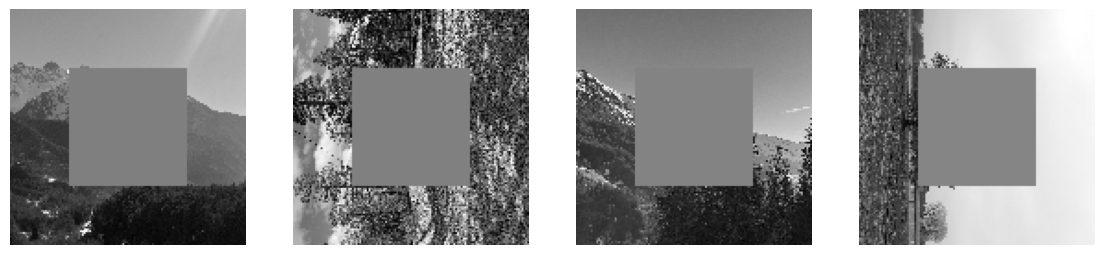

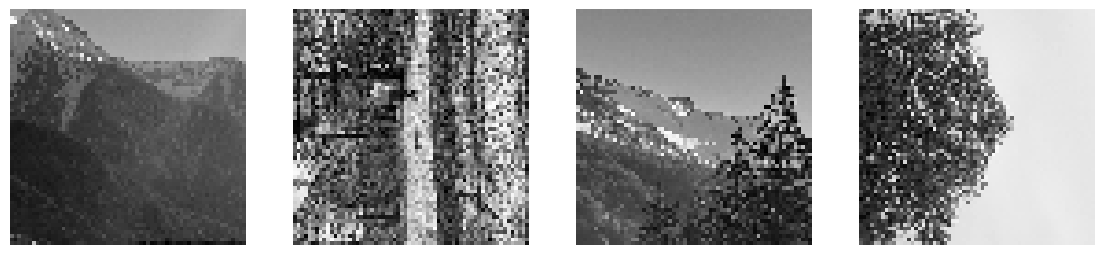

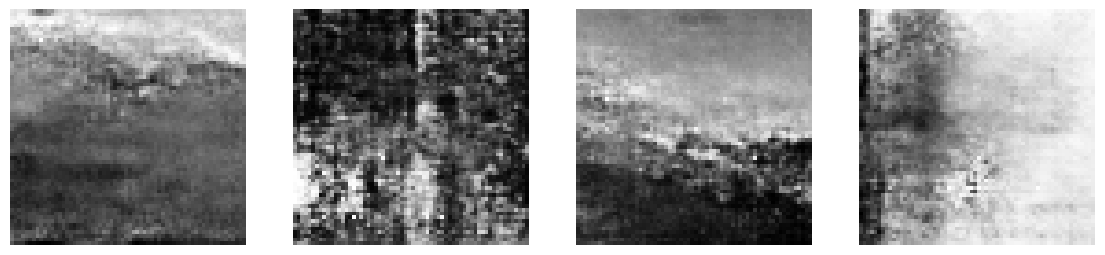

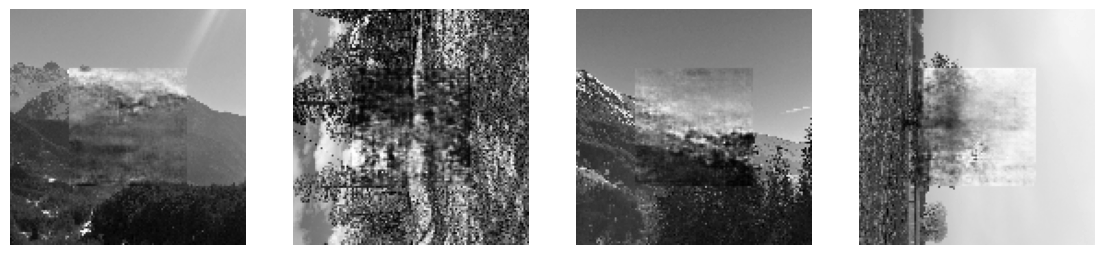

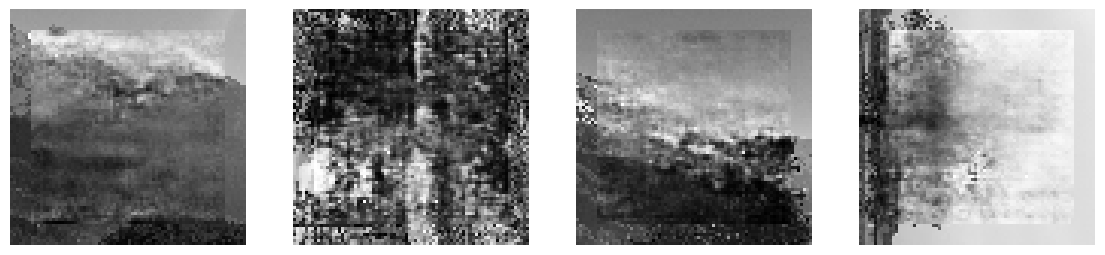

In [34]:
test_data = LandscapeDataset("own_data", image_transforms)
test_loader = DataLoader(test_data, batch_size=4, shuffle=True)
img = test_loader.__iter__().__next__()
patch_pos, patches, images = get_patchs(img)
padded_patch_pos, padded_patches, _ = get_patchs(img, patch_size=64+14)

show_images(images)
show_images(patches)

model.to("cpu")
predicted_patches = model(images).cpu().detach()
discriminator.to("cpu")
disc_predictions = discriminator(fill_patch((7,7), padded_patches, predicted_patches)).cpu().detach()

show_images(predicted_patches)
show_images(fill_patch(patch_pos, images, predicted_patches))
show_images(fill_patch((7,7), padded_patches, predicted_patches))
print(disc_predictions)


tensor([[1.],
        [1.],
        [1.],
        [1.]])


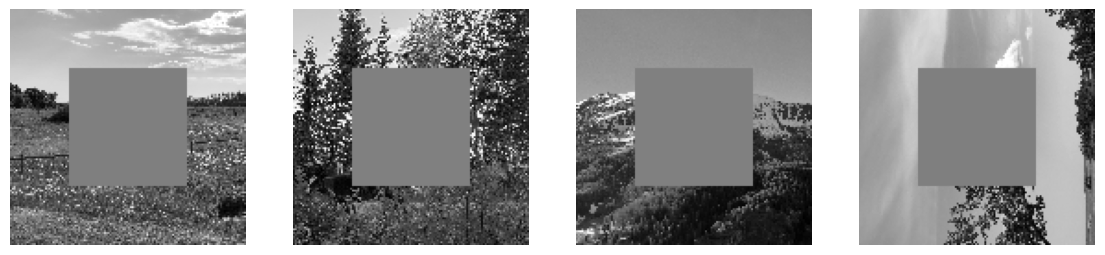

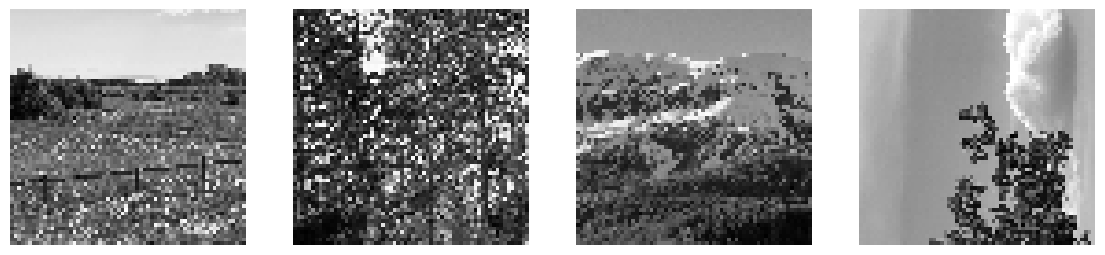

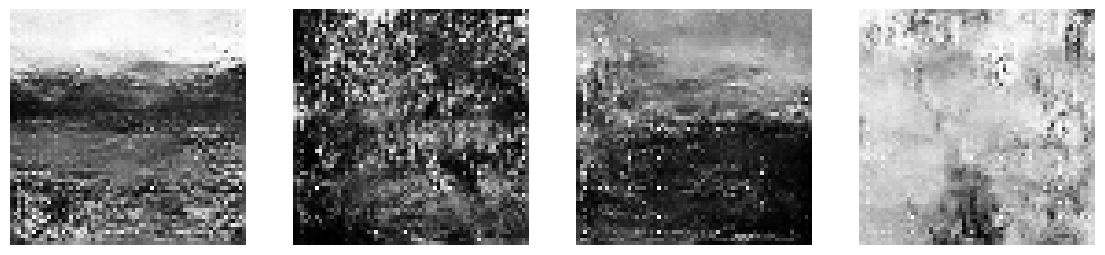

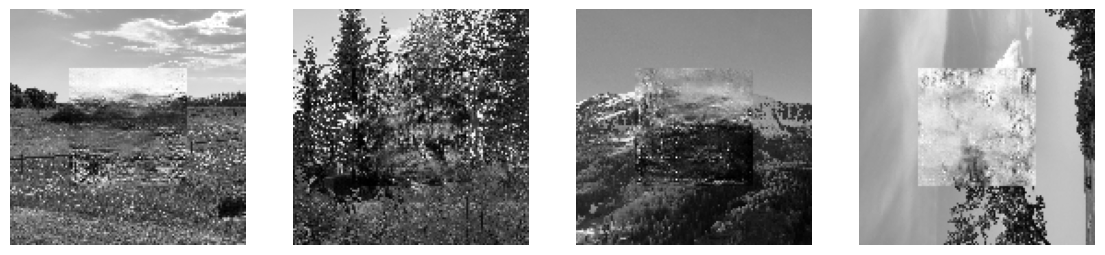

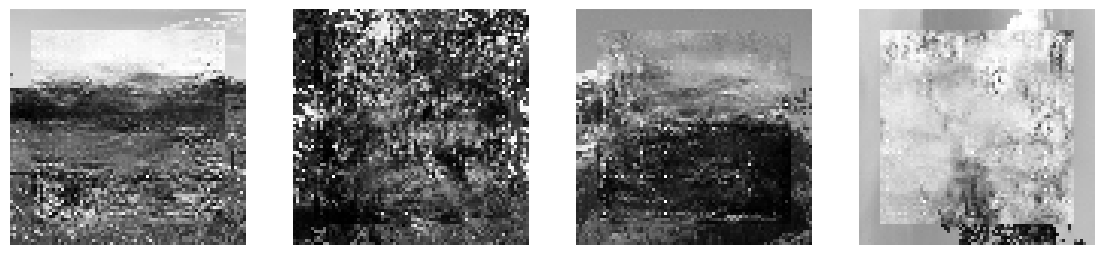

In [74]:
device = torch.device("cuda")
model = AutoEncoder()
model.load_state_dict(torch.load("models/90_64_mps/model_cpu.pt"))
model.to(torch.device("cuda"))

device = torch.device("cuda")
discriminator = Discriminator()
discriminator.load_state_dict(torch.load("models/90_64_mps/disc_cpu.pt"))
discriminator.to(torch.device("cuda"))

test_data = LandscapeDataset("own_data", image_transforms)
test_loader = DataLoader(test_data, batch_size=4, shuffle=True)
img = test_loader.__iter__().__next__()
patch_pos, patches, images = get_patchs(img)
padded_patch_pos, padded_patches, _ = get_patchs(img, patch_size=64+14)

show_images(images)
show_images(patches)

model.to("cpu")
predicted_patches = model(images).cpu().detach()
discriminator.to("cpu")
disc_predictions = discriminator(fill_patch((7,7), padded_patches, predicted_patches)).cpu().detach()

show_images(predicted_patches)
show_images(fill_patch(patch_pos, images, predicted_patches))
show_images(fill_patch((7,7), padded_patches, predicted_patches))
print(disc_predictions)
